# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

My Step by step for working out profits from each seller:

1. Work out profits by
- grouping by order_id and summing the price, this gives you the total price
- we can then create a new column which is profit, made up of 10% of the total price + 80 
- we can then group by seller_id to get the total profit

2. Work out the costs by
- creating a new column that will convert the score in review score into a reputation cost
- then group by seller_id and sum the reputation costs

3. 
- Now we can combine the two new columns together to create a profits column

In [50]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from olist.data import Olist
olist = Olist()
data = olist.get_data()

In [191]:
from olist.seller import Seller
sellers = Seller().get_active_dates()
sellers

,date_first_sale,date_last_sale,months_on_olist
seller_id,,,
0015a82c2db000af6aaaf3ae2ecb0532,2017-09-27 22:24:16,2017-10-18 23:56:20,1.0
001cca7ae9ae17fb1caed9dfb1094831,2017-02-04 19:15:39,2018-07-12 21:50:17,17.0
001e6ad469a905060d959994f1b41e4f,2018-08-07 23:05:23,2018-08-07 23:05:23,0.0
002100f778ceb8431b7a1020ff7ab48f,2017-09-14 01:10:15,2018-04-12 13:11:45,7.0
003554e2dce176b5555353e4f3555ac8,2017-12-15 07:11:03,2017-12-15 07:11:03,0.0
...,...,...,...
ffcfefa19b08742c5d315f2791395ee5,2018-06-23 17:55:45,2018-06-23 17:55:45,0.0
ffdd9f82b9a447f6f8d4b91554cc7dd3,2017-03-05 16:30:20,2018-08-20 12:11:53,18.0
ffeee66ac5d5a62fe688b9d26f83f534,2017-09-30 16:14:11,2018-05-16 03:33:54,7.0


In [192]:
sell_copy = sellers.copy()
sell_2 = sell_copy.assign(sub = lambda sell_copy: (sell_copy.months_on_olist+1)*80)
sell_2

,date_first_sale,date_last_sale,months_on_olist,sub
seller_id,,,,
0015a82c2db000af6aaaf3ae2ecb0532,2017-09-27 22:24:16,2017-10-18 23:56:20,1.0,160.0
001cca7ae9ae17fb1caed9dfb1094831,2017-02-04 19:15:39,2018-07-12 21:50:17,17.0,1440.0
001e6ad469a905060d959994f1b41e4f,2018-08-07 23:05:23,2018-08-07 23:05:23,0.0,80.0
002100f778ceb8431b7a1020ff7ab48f,2017-09-14 01:10:15,2018-04-12 13:11:45,7.0,640.0
003554e2dce176b5555353e4f3555ac8,2017-12-15 07:11:03,2017-12-15 07:11:03,0.0,80.0
...,...,...,...,...
ffcfefa19b08742c5d315f2791395ee5,2018-06-23 17:55:45,2018-06-23 17:55:45,0.0,80.0
ffdd9f82b9a447f6f8d4b91554cc7dd3,2017-03-05 16:30:20,2018-08-20 12:11:53,18.0,1520.0
ffeee66ac5d5a62fe688b9d26f83f534,2017-09-30 16:14:11,2018-05-16 03:33:54,7.0,640.0


In [162]:
#Merging the dataframes I want together
order_items = data['order_items'].copy()
order_reviews = data['order_reviews'].copy()
merged_1 = order_items.merge(order_reviews, how='left', on='order_id')
merged_1.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'review_id',
       'review_score', 'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp'],
      dtype='object')

In [181]:
#Working out total profit for each seller
temp1 = merged_1.groupby(['order_id','seller_id'], as_index=False)['price'].sum()
temp2 = temp1.assign(per_order = lambda temp1: temp1.price*0.1)
temp3 = temp2.groupby('seller_id').agg({'price':'sum','per_order':'sum'}).reset_index()
temp3
temp3.loc[temp3['seller_id']=='1025f0e2d44d7041d6cf58b6550e0bfa',['price']]


,price
192,140513.14


In [193]:
#Merging subscription to revenues
sell_3 = temp3.merge(sell_2, on='seller_id', how='left')
sell_3
sell_4 = sell_3.assign(revenues = lambda sell_3: sell_3['per_order']+sell_3['sub'])
sell_4

,seller_id,price,per_order,date_first_sale,date_last_sale,months_on_olist,sub,revenues
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,268.500,2017-09-27 22:24:16,2017-10-18 23:56:20,1.0,160.0,428.500
1,001cca7ae9ae17fb1caed9dfb1094831,25080.03,2508.003,2017-02-04 19:15:39,2018-07-12 21:50:17,17.0,1440.0,3948.003
2,001e6ad469a905060d959994f1b41e4f,250.00,25.000,2018-08-07 23:05:23,2018-08-07 23:05:23,0.0,80.0,105.000
3,002100f778ceb8431b7a1020ff7ab48f,1254.40,125.440,2017-09-14 01:10:15,2018-04-12 13:11:45,7.0,640.0,765.440
4,003554e2dce176b5555353e4f3555ac8,120.00,12.000,2017-12-15 07:11:03,2017-12-15 07:11:03,0.0,80.0,92.000
...,...,...,...,...,...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,69.90,6.990,2018-06-23 17:55:45,2018-06-23 17:55:45,0.0,80.0,86.990
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,2101.20,210.120,2017-03-05 16:30:20,2018-08-20 12:11:53,18.0,1520.0,1730.120
3092,ffeee66ac5d5a62fe688b9d26f83f534,1839.86,183.986,2017-09-30 16:14:11,2018-05-16 03:33:54,7.0,640.0,823.986
3093,fffd5413c0700ac820c7069d66d98c89,9062.30,906.230,2017-07-24 21:25:19,2018-08-26 20:10:15,13.0,1120.0,2026.230


In [194]:
#Function for converting review to reputation costs
def rep_cost(review):
    if review == 1:
        return 100
    elif review == 2:
        return 50
    elif review == 3:
        return 40
    else:
        return 0

In [195]:
#Determining the cost per seller
temp4 = merged_1.copy()
temp4.loc[:, 'review_score'] = temp4['review_score'].apply(rep_cost)
temp5 = temp4.groupby('seller_id').agg({'review_score':'sum'}).reset_index()
temp5

,seller_id,review_score
0,0015a82c2db000af6aaaf3ae2ecb0532,100
1,001cca7ae9ae17fb1caed9dfb1094831,4750
2,001e6ad469a905060d959994f1b41e4f,100
3,002100f778ceb8431b7a1020ff7ab48f,1110
4,003554e2dce176b5555353e4f3555ac8,0
...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,100
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,240
3092,ffeee66ac5d5a62fe688b9d26f83f534,200
3093,fffd5413c0700ac820c7069d66d98c89,1360


In [196]:
#Merging revenue and cost
merged_2 = sell_4.merge(temp5, on='seller_id', how='left')
merged_2

,seller_id,price,per_order,date_first_sale,date_last_sale,months_on_olist,sub,revenues,review_score
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,268.500,2017-09-27 22:24:16,2017-10-18 23:56:20,1.0,160.0,428.500,100
1,001cca7ae9ae17fb1caed9dfb1094831,25080.03,2508.003,2017-02-04 19:15:39,2018-07-12 21:50:17,17.0,1440.0,3948.003,4750
2,001e6ad469a905060d959994f1b41e4f,250.00,25.000,2018-08-07 23:05:23,2018-08-07 23:05:23,0.0,80.0,105.000,100
3,002100f778ceb8431b7a1020ff7ab48f,1254.40,125.440,2017-09-14 01:10:15,2018-04-12 13:11:45,7.0,640.0,765.440,1110
4,003554e2dce176b5555353e4f3555ac8,120.00,12.000,2017-12-15 07:11:03,2017-12-15 07:11:03,0.0,80.0,92.000,0
...,...,...,...,...,...,...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,69.90,6.990,2018-06-23 17:55:45,2018-06-23 17:55:45,0.0,80.0,86.990,100
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,2101.20,210.120,2017-03-05 16:30:20,2018-08-20 12:11:53,18.0,1520.0,1730.120,240
3092,ffeee66ac5d5a62fe688b9d26f83f534,1839.86,183.986,2017-09-30 16:14:11,2018-05-16 03:33:54,7.0,640.0,823.986,200
3093,fffd5413c0700ac820c7069d66d98c89,9062.30,906.230,2017-07-24 21:25:19,2018-08-26 20:10:15,13.0,1120.0,2026.230,1360


In [197]:
#Creating final profit column for each seller
temp6 = merged_2.copy()
temp7 = temp6.assign(profits = lambda temp6: temp6['revenues']-temp6['review_score'])

In [198]:
#Dataframe formatting (column renaming and removing)
temp8 = temp7.rename(columns = {'review_score':'review_costs'})
profits_df = temp8[['seller_id','revenues','review_costs','profits']]
profits_df

,seller_id,revenues,review_costs,profits
0,0015a82c2db000af6aaaf3ae2ecb0532,428.500,100,328.500
1,001cca7ae9ae17fb1caed9dfb1094831,3948.003,4750,-801.997
2,001e6ad469a905060d959994f1b41e4f,105.000,100,5.000
3,002100f778ceb8431b7a1020ff7ab48f,765.440,1110,-344.560
4,003554e2dce176b5555353e4f3555ac8,92.000,0,92.000
...,...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,86.990,100,-13.010
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,1730.120,240,1490.120
3092,ffeee66ac5d5a62fe688b9d26f83f534,823.986,200,623.986
3093,fffd5413c0700ac820c7069d66d98c89,2026.230,1360,666.230


In [238]:
sorted_profits = profits_df.copy()
sorted_profits.sort_values(by=['profits'], inplace=True)
sorted_profits.reset_index(drop=True, inplace=True)
sorted_profits

,seller_id,revenues,review_costs,profits
0,6560211a19b47992c3666cc44a7e94c0,13878.582,40120,-26241.418
1,1f50f920176fa81dab994f9023523100,12183.141,37490,-25306.859
2,7c67e1448b00f6e969d365cea6b010ab,20461.767,44290,-23828.233
3,4a3ca9315b744ce9f8e9374361493884,21979.912,44620,-22640.088
4,cc419e0650a3c5ba77189a1882b7556a,12255.598,31070,-18814.402
...,...,...,...,...
3090,ccc4bbb5f32a6ab2b7066a4130f114e3,9000.462,2300,6700.462
3091,edb1ef5e36e0c8cd84eb3c9b003e486d,8888.455,1570,7318.455
3092,7e93a43ef30c4f03f38b393420bc753a,19403.187,4840,14563.187
3093,fa1c13f2614d7b5c4749cbc52fecda94,21084.203,6510,14574.203


### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the products they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

In [200]:
profits_df['seller_id'].count()

3095

In [212]:
number_products = order_items.groupby(['product_id','seller_id']).agg({'price':'sum'}).reset_index()
number_products

,product_id,seller_id,price
0,00066f42aeeb9f3007548bb9d3f33c38,5670f4db5b62c43d542e1b2d56b0cf7c,101.65
1,00088930e925c41fd95ebfe695fd2655,7142540dd4c91e2237acb7e911c4eba2,129.90
2,0009406fd7479715e4bef61dd91f2462,4a3ca9315b744ce9f8e9374361493884,229.00
3,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,117.80
4,000d9be29b5207b54e86aa1b1ac54872,8ae520247981aa06bc94abddf5f46d34,199.00
...,...,...,...
34443,fff6177642830a9a94a0f2cba5e476d1,7a67c85e85bb2ce8582c35f2203ad736,229.98
34444,fff81cc3158d2725c0655ab9ba0f712c,778323240ce2830d68aab11794e00bfb,90.00
34445,fff9553ac224cec9d15d49f5a263411f,643214e62b870443ccbe55ab29a4dccf,32.00
34446,fffdb2d0ec8d6a61f0a0a0db3f25b441,9f505651f4a6abe901a56cdc21508025,169.95


In [202]:
def IT_costs(sellers,products):
    return 3157.3*(sellers)**0.5 + 978.23*(products)**0.5
#IT_costs(sorted_profits['seller_id'].count(),number_products['product_id'].count())

357210.37465798313

In [219]:
total_profit = profits_df['profits'].sum()
total_profit

1050992.347

In [241]:
sort_profs = sorted_profits.copy()
prod_copy = number_products.copy()

profit_margin = []

index_values = sorted_profits.index.to_list()
totaling_profit = 0

for i in index_values:
    dropped_seller = sorted_profits['seller_id'].iloc[i]
    lost_profit = sort_profs[sort_profs['seller_id'] == dropped_seller]['profits'].values[0]
    totaling_profit += lost_profit
    sorted_count = sort_profs['seller_id'].count()
    prod_count = prod_copy['product_id'].count()
    prod_copy = prod_copy[prod_copy['seller_id'] != dropped_seller]
    sort_profs = sort_profs[sort_profs['seller_id'] != dropped_seller]
    profit_margin.append(total_profit - IT_costs(sorted_count,prod_count) - totaling_profit)
    
profit_margin


[720023.3903420168,
 746034.5210963164,
 769951.985723358,
 793145.1367078001,
 813049.8970115331,
 830976.5399590044,
 847632.198060425,
 863900.1916536334,
 877935.7010593328,
 889587.9150335495,
 899970.620995542,
 909952.5582676783,
 920360.01555667,
 928759.0661007266,
 937236.2895872844,
 944567.9241368247,
 951262.8088694565,
 957326.5259531282,
 963627.4799687823,
 969897.1435507461,
 975951.5190950225,
 981657.2961609035,
 986834.9771222954,
 992080.4312712976,
 997006.8905722392,
 1001698.415272042,
 1006608.2975805985,
 1011468.2899479426,
 1015903.1127711062,
 1019952.3967188173,
 1023733.6082977823,
 1027343.589072752,
 1031028.2556354846,
 1035396.3262404911,
 1038990.0017725453,
 1042484.2543835469,
 1046107.7937857662,
 1049233.1616138415,
 1052357.5407802693,
 1055457.2914907094,
 1058585.195619218,
 1061573.2379344674,
 1064812.8882829614,
 1067937.412633691,
 1070421.8110276782,
 1073021.4834751044,
 1075553.1496533765,
 1078373.0460581519,
 1080685.1919718836,
 1083

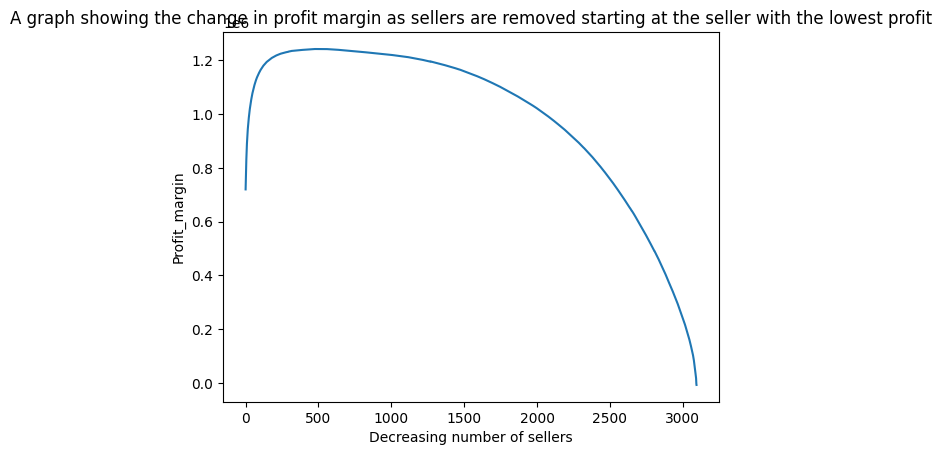

In [242]:
x = range(len(profit_margin))
plt.plot(x, profit_margin)
plt.xlabel('Decreasing number of sellers')
plt.ylabel('Profit_margin')
plt.title('A graph showing the change in profit margin as sellers are removed starting at the seller with the lowest profit')
plt.show()

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪